# Module 07: Time Series Analysis with TimesFM and ARIMA in BigQuery [Needs tuning]

## 1. Introduction

Accurate and granular demand forecasting is critical for managing retail inventory, but forecasting for every individual item and location is a major operational challenge. This tutorial demonstrates how to perform scalable time series forecasting directly in [BigQuery](https://cloud.google.com/bigquery/docs/introduction), on the retail dataset in the lab as a practical example.

In this notebook, you will compare two distinct approaches to generate forecasts:
* **A Trained Model:** train a traditional [**ARIMA**](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series) model and generating predictions with [BigQuery Machine Learning](https://cloud.google.com/bigquery/docs/bqml-introduction).
* **A Zero Shot Model:** use [**TimesFM**](https://github.com/google-research/timesfm), a foundation model, to generate predictions directly from the data with no model training required.

You will apply both methods to a single aggregated time series and then scale to multiple series to see how each performs at a granular level.


This notebook is an adaptation of Google Cloud public sample at - https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/forecast/arima_timesfm_bigquery.ipynb


**Note:** The notebook offers a simple demonstration. Refining is needed to improve accuracy of the forecast such as **adding prediction bounds** to show the daily volatility in the forecast to mirror the volatility in the actuals. This refining can be a challenge activity for the lab user.

## 2. Objectives

You will learn to:

* Prepare raw data for time series forecasting scenarios in BigQuery
* Build a traditional forecasting model using [`CREATE MODEL`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series) AND generate predictions with [`ML.FORECAST`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-forecast) (ARIMA)
* Generate zero-shot forecasts directly from data using the [`AI.FORECAST`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ai-forecast) function (TimesFM)
* Scale your analysis from a single time series to multiple time series
* Visualize and compare the outputs to understand the tradeoffs between the two methods

## 3. Set up



In [1]:
PROJECT_ID_LIST=!gcloud config list --format "value(core.project)" 2>/dev/null
PROJECT_ID=PROJECT_ID_LIST[0]
LOCATION="us-central1"
FORECASTING_DS="rscw_forecasting_ds"

#### 3.1. Create a BigQuery Dataset

Running the following query creates a [BigQuery dataset](https://cloud.google.com/bigquery/docs/datasets-intro) called **`rscw_forecasting_ds`** to house any tables or models created in this tutorial:

In [2]:
%%bigquery --project {PROJECT_ID}

CREATE SCHEMA `rscw_forecasting_ds` OPTIONS (location = 'us-central1');

Executing query with job ID: 2ba707c4-92b2-4b6a-ba85-96c330428540
Query executing: 0.27s


ERROR:
 409 Already Exists: Dataset data-insights-quickstart:rscw_forecasting_ds; reason: duplicate, message: Already Exists: Dataset data-insights-quickstart:rscw_forecasting_ds

Location: us-central1
Job ID: 2ba707c4-92b2-4b6a-ba85-96c330428540



### 3.2. Set Colab display options

Colab includes the `google.colab.data_table` package that can be used to display large pandas dataframes as an interactive data table. It can be enabled with:

In [3]:
%load_ext google.colab.data_table

# 4. Time Series Forecasting with BigQuery



## 4.1. Data in scope

This tutorial uses the `table rscw_ml_ds.customer_purchases_history` table


In [5]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE TABLE
    `rscw_ml_ds.customer_purchases_history` AS
SELECT
    t.transaction_id,
    t.location_id,
    t.customer_id,
    t.transaction_status,
    t.transaction_dt,
    t.payment_type,
    t.payment_total_dollar,
    ti.product_id,
    pm.product_nm,
    ti.quantity,
    ti.price,
    ti.line_item_total,
    cm.first_nm,
    cm.last_nm,
    cm.email,
    cm.address,
    cm.city,
    cm.state_cd,
    cm.zip_cd,
    cm.country_cd,
    cm.phone_nbr
  FROM
    `rscw_iceberg_curated_ds.pos_transactions` AS t
    INNER JOIN `rscw_iceberg_curated_ds.pos_transaction_items` AS ti ON t.transaction_id = ti.transaction_id
    INNER JOIN `rscw_iceberg_curated_ds.product_master` AS pm ON ti.product_id = pm.product_id
    INNER JOIN `rscw_iceberg_raw_ds.customer_master` AS cm ON t.customer_id = cm.customer_id

Query is running:   0%|          |

""


## 4.2. Data curation for forecasting

The `customer_purchases_history` table can contain multiple rows for each date / store / item / other field combination. For this tutorial, we'll aggregate the table to generate total sales for each field we're interested in forecasting (e.g. `date`, `item_description`).

We'll create two tables for two intended use cases:

| Table | Granularity | Usage |
|---|---|---|
| sales_training_single | `total_sales` by transaction_dt | Single time series |
| sales_training_multiple | `total_sales` by multiple fields, including `item_nm`| Multiple time series |

In [6]:
%%bigquery --project {PROJECT_ID}

-- SALES AGGREGATED BY DATE, STORE, ITEM_NM
CREATE OR REPLACE TABLE rscw_forecasting_ds.sales_training_multiple AS (
WITH top_sellers AS(
      SELECT
        product_nm as item_nm,
        SUM( line_item_total ) AS total_sales
    FROM
        `rscw_ml_ds.customer_purchases_history`
    GROUP BY
        item_nm
    ORDER BY total_sales DESC
    LIMIT 25
)
SELECT
    EXTRACT(DATE FROM transaction_dt) as transaction_dt,
    location_id,
    product_nm AS item_nm,
    SUM( line_item_total ) AS total_sales
FROM
    `rscw_ml_ds.customer_purchases_history`
GROUP BY transaction_dt, location_id, item_nm
HAVING
    transaction_dt BETWEEN '2010-01-01' AND '2025-12-31'
    AND item_nm IN (SELECT item_nm FROM top_sellers)
);

-- SALES AGGREGATED BY DATE
CREATE OR REPLACE TABLE rscw_forecasting_ds.sales_training_single AS (
SELECT
    transaction_dt,
    SUM( total_sales ) AS total_sales
FROM
    rscw_forecasting_ds.sales_training_multiple
GROUP BY transaction_dt
);

Query is running:   0%|          |

""


## 4.3. Forecasting a Single Time Series

In time series forecasting, a simple scenario is a **single time series**. This means we are looking to predict a single variable over time. Think of it as having one column for your dates and one column for the value you want to predict.

**Scenario: Total Sales Over Time**

For this example, we'll forecast `total_sales` over time. We aren't breaking down sales by any other category. We will take two approaches using BigQuery ML and see how they compare:

1. **ARIMA**: A widely used statistical model that requires you to explicitly train a model on historical data.
2. **TimesFM**: A pre-trained foundation model that allows you to generate a forecast with a simple function call, no training required.

### 4.3.1. Method A: ARIMA

#### 4.3.1.1. Create a Model

Before we can get a forecast, we need to train a dedicated model on our historical data. In BigQuery ML, we accomplish this using the `CREATE MODEL` statement, where we specify our timestamp column (`date`) and the data column we want to forecast (`total_sales`).

In [7]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE MODEL rscw_forecasting_ds.arima_model_single
OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='transaction_dt',
  TIME_SERIES_DATA_COL='total_sales',
  CLEAN_SPIKES_AND_DIPS=TRUE,
  SEASONALITIES=['MONTHLY']
) AS
SELECT
    transaction_dt,
    total_sales
FROM
  rscw_forecasting_ds.sales_training_single;

Query is running:   0%|          |

""


#### 4.3.1.2. Generate a Forecast

With our `arima_model_single` now trained, we can use it to generate the actual forecast. We do this with the `ML.FORECAST` function. This function takes our trained model as input and requires us to specify the `horizon` (the number of future time steps we want to predict), and a confidence level. It returns the forecasted values.

In [8]:
%%bigquery df_arima --project {PROJECT_ID}

SELECT *
FROM ML.FORECAST(MODEL rscw_forecasting_ds.arima_model_single,
       STRUCT(30 AS horizon,
              0.95 AS confidence_level)
      );

Query is running:   0%|          |

Downloading:   0%|          |

#### 4.3.1.3. Prepare Historical Data for Visualization

Retrieve historical sales data for the single time series, which will be used for visualizing the ARIMA forecast.

In [9]:
%%bigquery df_history --project {PROJECT_ID}

SELECT
    transaction_dt,
    total_sales
FROM
  rscw_forecasting_ds.sales_training_single
WHERE
  transaction_dt BETWEEN '2025-01-01' AND '2025-09-03'
ORDER BY transaction_dt

Query is running:   0%|          |

Downloading:   0%|          |

#### 4.3.1.4. Visualize the Forecast

To check out our model, we can plot the historical sales data against the forecasted values and their 95% confidence interval.

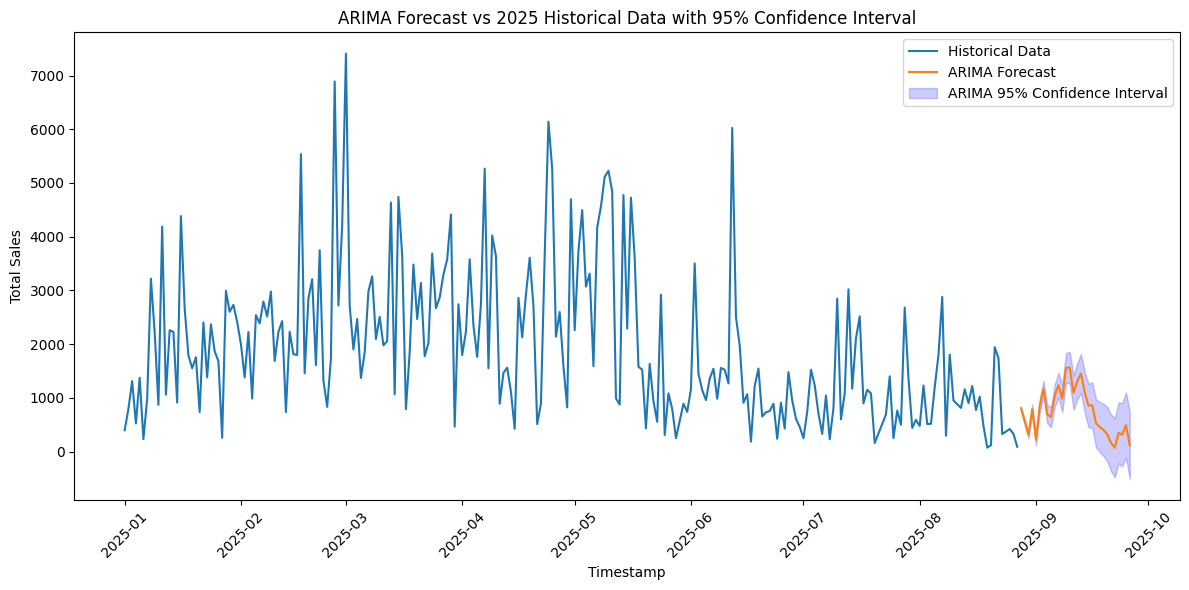

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_history['transaction_dt'], df_history['total_sales'], label='Historical Data')
plt.plot(df_arima['forecast_timestamp'], df_arima['forecast_value'], label='ARIMA Forecast')
plt.fill_between(df_arima['forecast_timestamp'], df_arima['prediction_interval_lower_bound'], df_arima['prediction_interval_upper_bound'], color='blue', alpha=0.2, label='ARIMA 95% Confidence Interval')
plt.xlabel('Timestamp')
plt.ylabel('Total Sales')
plt.title('ARIMA Forecast vs 2025 Historical Data with 95% Confidence Interval')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 4.3.1.5. Observations

**Note:** There is high volatility in the data, And Arima has been conservative. There are knobs/boundary configurations that can be applied for a more realistic forecast. This can be taken on as a challenge assignment by the lab user.

---

### 4.3.2. Method B: TimesFM

Our second method uses TimesFM, which operates differently from "traditional" models like ARIMA. TimesFM is a pre-trained foundation model, meaning the complex model training has already been done. As a result, we can skip the `CREATE MODEL` step entirely and apply it directly to our data for a zero-shot forecast.


#### 4.3.2.1. Generate a Forecast

To get our forecast, we use the [`AI.FORECAST`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ai-forecast) function. Unlike the two-step process for ARIMA (create, then forecast), this single function takes our historical data table directly as its input. We just configure the forecast by passing arguments for the `horizon`, `timestamp_col`, and `data_col`. Then, BigQuery returns the predicted values in one go.

Below is a quick look at 5 forecasted days.

In [19]:
%%bigquery --project {PROJECT_ID}

SELECT *
FROM
  AI.FORECAST(
    (
      SELECT *
      FROM rscw_forecasting_ds.sales_training_single
    ),
    horizon => 5,
    confidence_level => 0.95,
    timestamp_col => 'transaction_dt',
    data_col => 'total_sales')
  ;

Query is running:   0%|          |

Downloading:   0%|          |

,forecast_timestamp,forecast_value,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,ai_forecast_status
0,2025-08-28 00:00:00+00:00,745.686829,0.95,-228.981525,1720.355182,
1,2025-08-29 00:00:00+00:00,674.339844,0.95,-261.355743,1610.035431,
2,2025-08-30 00:00:00+00:00,696.712708,0.95,-269.366687,1662.792102,
3,2025-08-31 00:00:00+00:00,594.708984,0.95,-361.635309,1551.053277,
4,2025-09-01 00:00:00+00:00,505.561218,0.95,-470.100156,1481.222593,


#### 4.3.2.2. Prepare TimesFM Data for Plotting

Let's expand the horizon to 30 days of forecasted data and save it to a DataFrame called `df_timesfm` so we can plot it alongside the ARIMA predictions.

In [12]:
%%bigquery df_timesfm --project {PROJECT_ID}

SELECT *
FROM
  AI.FORECAST(
    (
      SELECT *
      FROM rscw_forecasting_ds.sales_training_single
    ),
    horizon => 30,
    confidence_level => 0.95,
    timestamp_col => 'transaction_dt',
    data_col => 'total_sales')
  ;

Query is running:   0%|          |

Downloading:   0%|          |

---

### 4.3.3. Compare ARIMA and TimesFM Forecasts

Plotting the results together provides a clear, side-by-side comparison. We can see that both models successfully identified the strong weekly seasonality in the sales data. However, the ARIMA forecast consistently underestimates the peaks of the sales cycles, while the TimesFM forecast appears to capture the magnitude of the recent historical data more accurately.

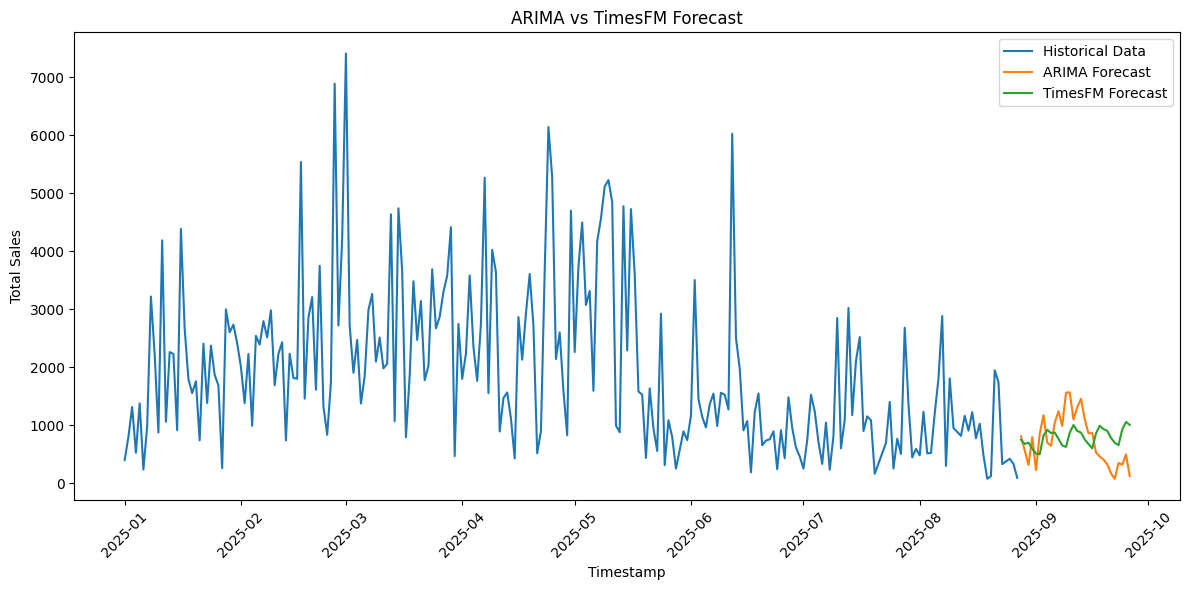

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_history['transaction_dt'], df_history['total_sales'], label='Historical Data')
plt.plot(df_arima['forecast_timestamp'], df_arima['forecast_value'], label='ARIMA Forecast')
plt.plot(df_timesfm['forecast_timestamp'], df_timesfm['forecast_value'], label='TimesFM Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Total Sales')
plt.title('ARIMA vs TimesFM Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.3.4. Observations

Both models have been conservative given the historical volatility, with TimesFM more conservative.

### 4.3.5. Forecasting a single time series - recap

In this scenario we:
* Addressed a single time series problem by forecasting `total_sales` based on `transaction_dt`.
* Used a two-step process to first train an `ARIMA_PLUS` model with the `CREATE MODEL` statement, and then generate predictions using `ML.FORECAST`.
* Used a one-step, zero-shot approach to generate a forecast directly from the data using `AI.FORECAST` and the TimesFM model.
* Plotted both forecasts alongside the historical data to visually compare the outputs from each method.


---


## 4.4. Forecasting Multiple Time Series

Forecasting a single series is useful, but most real-world scenarios require more granularity. With **multiple time series forecasting**, we can predict many individual time series at the same time. Instead of one forecast for `total_sales` by date, we will generate a unique forecast for every combination of `location_id` and `item_nm`. This is powerful for tasks like inventory management and revenue predictions.

Handling this complexity in BigQuery is straightforward. We simply specify which columns uniquely identify each individual time series. Both the ARIMA and TimesFM methods support a parameter that tells BigQuery to partition the data, treating each unique ID as a separate series to be forecasted. With this addition, we can scale forecasting efforts from a _single_ series to thousands or more, without a significant change to our workflow.

### 4.4.1. Method A: ARIMA

Once again, we will start with the ARIMA model. This process is very similar to the single series example, but with an additional parameter to tell BigQuery how to handle different series within our dataset.

#### 4.4.1.1. Create a Model

To train the model on multiple time series simultaneously, we introduce the `TIME_SERIES_ID_COL` option. This parameter accepts an array of column names that uniquely identify each series. In our case, the input table is uniquely identified by a combination of `date` and the array [`location_id`, `item_nm`].

BigQuery now partitions the data by these IDs and trains a distinct ARIMA model for each individual time series behind the scenes.



In [14]:
%%bigquery --project {PROJECT_ID}

CREATE OR REPLACE MODEL rscw_forecasting_ds.arima_model_multiple
OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='transaction_dt',
  TIME_SERIES_DATA_COL='total_sales',
  TIME_SERIES_ID_COL=['location_id','item_nm'],
  CLEAN_SPIKES_AND_DIPS=TRUE,
  SEASONALITIES=['MONTHLY']
) AS
SELECT
    transaction_dt,
    total_sales,
    location_id,
    item_nm
FROM
  rscw_forecasting_ds.sales_training_multiple;

Query is running:   0%|          |

""


#### 4.4.1.2. Generate a Forecast

After the model is trained, the process to generate a forecast is identical to what we did before. We use the `ML.FORECAST` function to call our new model (`arima_model_multiple`), which inherently understands it needs to produce a separate forecaste for each unique `location_id` and `item_nm` combination.

The result contains forecasts for all series. To make sense of the output, we will filter the results to visualize the forecast for single, specific series.

In [15]:
%%bigquery df_arima_multiple --project {PROJECT_ID}

SELECT *
FROM ML.FORECAST(MODEL rscw_forecasting_ds.arima_model_multiple,
       STRUCT(50 AS horizon,
              0.95 AS confidence_level)
      )
WHERE location_id = 'CHI-IL-ST'
AND item_nm = "Revitalize Hair Dryer";

Query is running:   0%|          |

Downloading:   0%|          |

### 4.4.2. Method B: TimesFM

Adapting the TimesFM approach for multiple time series is just as straightforward. Since we don't have a model to create, we only need to add one parameter to the existing `AI.FORECAST` query to make it aware of the different series within our data.

#### 4.4.2.1. Generate a Forecast

The process remains a single-step query, with the key addition of the `id_cols` parameter. We simply pass an array of column names (`['location_id', 'item_nm']`) to tell the function that each unique combination defines a separate time series.

The `AI.FORECAST` function computes a forecast for every series in the dataset. As shown in the code, you can use a standard WHERE clause to output and easily filter the results for a specific series of interest. In this case, we'll look at one item in s specific store location.

In [20]:
%%bigquery df_timesfm_multiple --project {PROJECT_ID}

SELECT *
FROM
  AI.FORECAST(
    (
      SELECT *
      FROM rscw_forecasting_ds.sales_training_multiple
    ),
    horizon => 50,
    confidence_level => 0.95,
    timestamp_col => 'transaction_dt',
    data_col => 'total_sales',
    id_cols => ['location_id', 'item_nm']
    )
  WHERE location_id = 'CHI-IL-ST'
  AND item_nm = "Revitalize Hair Dryer"
  ;

Query is running:   0%|          |

Downloading:   0%|          |

### 4.4.3. Compare Forecasts for a Single Series

Now, let's plot the two forecasts for 'Revitalize Hair Dryer' in 'CHI-IL-ST' store to visually compare their performance at a granular level. First, we need to retrieve the relevant historical data for our plot.

In [17]:
%%bigquery df_history_multiple --project {PROJECT_ID}

SELECT
    transaction_dt,
    location_id,
    item_nm,
    total_sales
FROM
  rscw_forecasting_ds.sales_training_multiple
WHERE
  transaction_dt BETWEEN '2025-01-01' AND '2025-09-03'

Query is running:   0%|          |

Downloading:   0%|          |

Our query retrieved all historical data for the last few months. Before we can plot, we'll use pandas to filter this DataFrame down to the specific `location_id` and `item_nm` that matches our forecasts.

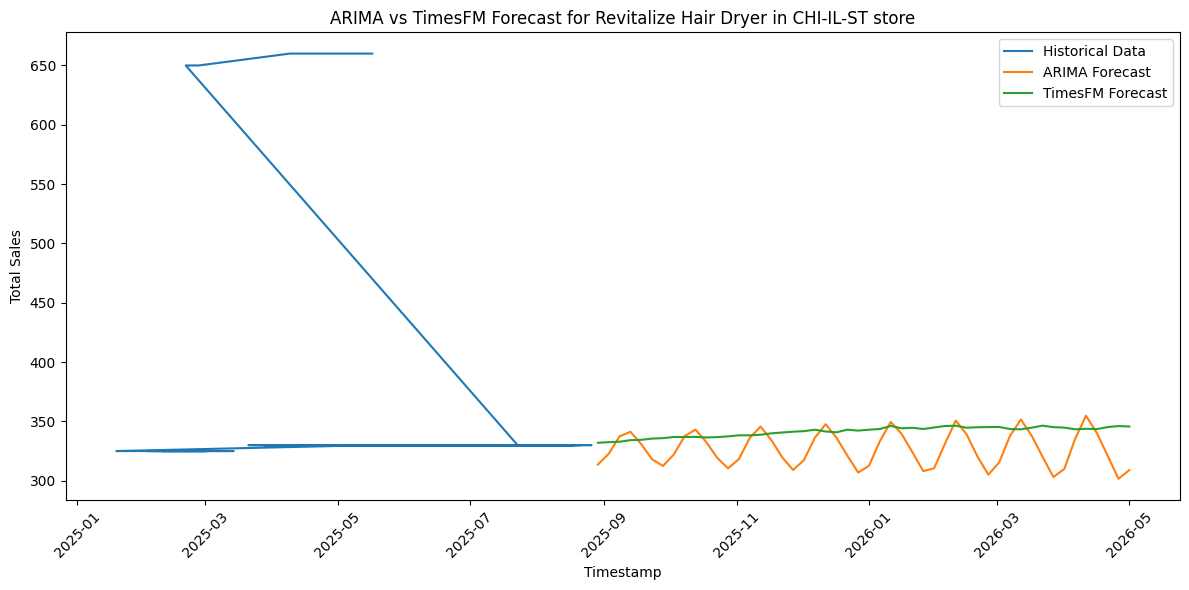

In [18]:
df_history_filtered = df_history_multiple[(df_history_multiple['location_id'] == 'CHI-IL-ST') & (df_history_multiple['item_nm'] == "Revitalize Hair Dryer")]
plt.figure(figsize=(12, 6))
plt.plot(df_history_filtered['transaction_dt'], df_history_filtered['total_sales'], label='Historical Data')
plt.plot(df_arima_multiple['forecast_timestamp'], df_arima_multiple['forecast_value'], label='ARIMA Forecast')
plt.plot(df_timesfm_multiple['forecast_timestamp'], df_timesfm_multiple['forecast_value'], label='TimesFM Forecast')
plt.xlabel('Timestamp')
plt.ylabel('Total Sales')
plt.title("ARIMA vs TimesFM Forecast for Revitalize Hair Dryer in CHI-IL-ST store")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.4.4. Observations

As with the single series, both models capture the general sales patterns. But the difference in their approaches becomes much clearer at this granular level. The **ARIMA forecast is notably more volatile**, attempting to predict the full amplitude of the historical peaks and troughs. In contrast, the **TimesFM forecast is smoother**, capturing the cyclical trend with a more conservative range.

It's important to look at these forecasts visually, because it highlights the importance of evaluating models not just on aggregate data but also on the individual series that drive key business decisions.

### 5. Module recap

In this section, we:
* Moved to multiple time series, forecasting `total_sales` for each unique combination of `location_id` and `item_nm`.
* Adapted our ARIMA model by adding the `TIME_SERIES_ID_COL` parameter to the `CREATE MODEL` statement.
* Adapted our TimesFM query by adding the `id_cols` parameter to the `AI.FORECAST` function.
* Demonstrated how a single parameter change in BigQuery allows us to easily scale our forecasting efforts from one to many individual series.

### 6. Choosing Your Model: Key Trade-Offs

Both ARIMA and TimesFM are powerful approaches, but they are suited for different scenarios. The choice often comes down to a trade-off between detailed statistical explainability and the speed of zero-shot forecasting.

* **Choose ARIMA** when you need more control and detailed statistical insights from your model, like detected seasonality and trend components.
* **Choose TimesFM** when your priority is generating high-quality forecasts quickly and at scale, especially when you need to automate forecasting without a dedicated training step for each series.

For a more detailed breakdown of the differences, see the [forecasting overview in the BigQuery documentation](https://cloud.google.com/bigquery/docs/forecasting-overview).

---

## This concludes the module, proceed to the user manual.